In [ ]:
# Author: Daniel Wagner
# Date: 2023-04-17
# This code was produced as part of my Master's thesis at FAU Erlangen in cooperation with McGill University Montreal


#####
# Credit goes to Claudia Antunes for some code snippets
# http://web.ist.utl.pt/~claudia.antunes/DSLabs/
#####

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE

In [150]:
def plot_hist(data):
    # plot 3x5 histogram of all variables
    fig, axs = plt.subplots(3, 5, figsize=(15, 10))
    for i, var in enumerate(data.columns):
        data[var].hist(ax=axs[i//5, i%5], bins=100)
        axs[i//5, i%5].set_title(var)
    plt.show()

# Preparing Exaggerate Dataset

In [53]:
# load exaggerate dataset
exaggerate = pd.read_csv('exaggerate/data/working_sheet.csv', sep=";")
target='aecopd_12m'
# rename variables for more practical handling
exaggerate = exaggerate.rename(columns={'sex': 'gender', 'dyspnoea_mMRC': 'mmrc', 'ami':'myocardial_infarct', 'cbd':'stroke', 'dyspnoea_yesno':'dyspnoea', target:'target'})
relevant_vars=['gender', 'age', 'bmi', 'sbp', 'dbp', 'cancer', 'diabetes', 'heart_failure', 'temperature', 'rr', 'myocardial_infarct', 'stroke', 'dyspnoea', 'mmrc', 'target']

# drop irrelevant variables
exaggerate = exaggerate[relevant_vars]

# sort columns
exaggerate = exaggerate.reindex(sorted(exaggerate.columns), axis=1)

# correct bmi scale.

# if bmi is between 100 and 1000, then divide by 10 to get the correct scale
exaggerate.loc[(exaggerate['bmi'] > 100) & (exaggerate['bmi'] < 1000), 'bmi'] = exaggerate['bmi'] / 10
# if bmi is betweeen 1000 and 10000 then divide by 100 to get the correct scale
exaggerate.loc[(exaggerate['bmi'] > 1000) & (exaggerate['bmi'] < 10000), 'bmi'] = exaggerate['bmi'] / 100

# correct the temperature scale (if temperature is between 100 and 1000, then divide by 10 to get the correct scale)
exaggerate.loc[(exaggerate['temperature'] > 100) & (exaggerate['temperature'] < 1000), 'temperature'] = exaggerate['temperature'] / 10

# create fever variable
exaggerate['fever'] = 0
# according to CDC, john hopkins etc. fever is defined as a temperature of 38 degrees or higher
exaggerate.loc[exaggerate['temperature'] > 38, 'fever'] = 1
exaggerate = exaggerate.drop(columns=['temperature'])

# create fast_breathing variable
exaggerate['fast_breathing'] = 0
# clinically normal respiratory rate is 12 - 20 anything above is considered fast breathing for adults
exaggerate.loc[exaggerate['rr'] > 20, 'fast_breathing'] = 1
exaggerate = exaggerate.drop(columns=['rr'])

# plot_hist(exaggerate)

########
# Missing values
########



# print(exaggerate.shape)
# drop rows with more than 85% missing values
exaggerate = exaggerate.dropna(thresh=0.70*exaggerate.shape[1], axis=0)

# drop all rows where mmrc is missing
# exaggerate = exaggerate.dropna(subset=['mmrc'], axis=0)

# reset index to be sequential again
exaggerate = exaggerate.reset_index(drop=True)
# print(exaggerate.shape)

# print missing values in a table for each variable
# print("missing values in the dataset: ")
# print(exaggerate.isna().sum())


# impute mmrc values using median and store it for later
# mmrc = exaggerate['mmrc'].fillna(exaggerate['mmrc'].median())

# imputer = IterativeImputer(random_state=42)
# imputed = imputer.fit_transform(exaggerate)
# exaggerate = pd.DataFrame(imputed, columns=exaggerate.columns)


# plot 2x5 histograms for each variable


# print missing values in a table for each variable
# print("missing values in the dataset after: ")
# print(exaggerate.isna().sum())

numeric_vars = ['age', 'bmi', 'sbp', 'dbp']
for var in numeric_vars:
    exaggerate[var] = exaggerate[var].fillna(exaggerate[var].median())

categorical_vars = ['gender', 'cancer', 'diabetes', 'heart_failure', 'mmrc', 'target', 'fever', 'fast_breathing', 'myocardial_infarct', 'stroke', 'dyspnoea']
for var in categorical_vars:
    exaggerate[var] = exaggerate[var].fillna(exaggerate[var].mode()[0])


# plot_hist(exaggerate)

#########
# Outliers
#########

# dealing with outliers is not necessary in this dataset

########
# Feature Engineering
########

# create a new variable for hypertension. If sbp variable is greater than 140 or dbp variable is greater than 90, then hypertension is 1, otherwise 0
exaggerate['hypertension'] = 0
exaggerate.loc[(exaggerate['sbp'] > 140) | (exaggerate['dbp'] > 90), 'hypertension'] = 1

# drop sbp and dbp columns
exaggerate = exaggerate.drop(columns=['sbp', 'dbp'])

# drop mmrc column for now
# exaggerate = exaggerate.drop(columns=['mmrc'])

#Cardiovascular disease was defined as heart failure, acute myocardial infarction, cerebrovascular disease, or peripheral arterial disease


##########
# Normalization
##########



numeric_vars = ['age', 'bmi', 'mmrc']
df_nr = exaggerate[numeric_vars]
df_rest = exaggerate.drop(columns=numeric_vars)
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=exaggerate.index, columns=numeric_vars)
exaggerate= concat([tmp, df_rest], axis=1)

############
# Target variable
############

# Binarize the target variable if data in target column is above 0, then set it to 1 else 0
# print("target variable value counts: ")
# print(exaggerate['target'].value_counts())
exaggerate.loc[exaggerate['target'] > 0, 'target'] = 1


# convert target to 4 classes like in harvard dataset
# exaggerate_data.loc[(exaggerate_data['target'] > 1) & (exaggerate_data['target'] <= 5), 'target'] = 2
# exaggerate_data.loc[(exaggerate_data['target'] > 5) & (exaggerate_data['target'] <= 10), 'target'] = 3
# exaggerate_data.loc[(exaggerate_data['target'] > 10), 'target'] = 4
# # add one to all target classes
# exaggerate_data['target'] = exaggerate_data['target'] + 1

exaggerate = exaggerate.reindex(sorted(exaggerate.columns), axis=1)
exaggerate.to_csv('exaggerate/data/imputed_hypertension.csv', index=False, sep=';')


# print(exaggerate['target'].value_counts())

# get rid of any nan values in the dataset
exaggerate = exaggerate.dropna()

# use smote to rebalance the exaggerate dataset in place
# print("perform smote")
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(exaggerate.drop(columns=['target']), exaggerate['target'])
X_res['target'] = y_res
exaggerate = X_res


# print(X_res['target'].value_counts())


# plot_hist(exaggerate)

# TODO there is something wrong with target value distribution

# save the new dataset
exaggerate.to_csv('exaggerate/data/harvard_cv.csv', index=False, sep=';')

# Preparing Harvard Dataset

In [54]:
target = 'bclinpt24'

relevant_vars = ['dem02', 'dem03', 'bclinra01', 'bclinra02', 'bclinpt19', 'bclinpt04', 'bclinpt15', 'mmrc', 'bclinpt07', 'bclinpt34', 'bclinpt36', 'bclinpt08', 'bclinpt09', 'bclinpt28', target]

# load harvard dataset
harvard = pd.read_csv('harvard/data/dropped_variables.csv', sep=";")
harvard = harvard[relevant_vars]

# change mmrc by starting at 0 instead of 1
harvard['mmrc'] = harvard['mmrc'] - 1

# change gender by starting at 0 instead of 1
harvard['dem03'] = harvard['dem03'] - 1

# rename columns to common names with exaggerate
harvard = harvard.rename(columns={'dem02':'age', 'dem03': 'gender', 'bclinpt19': 'cancer', 'bclinpt04': 'hypertension', 'bclinpt15': 'diabetes', 'bclinpt07': 'heart_failure', target: 'target', 'bclinra01': 'height', 'bclinra02': 'weight', 'bclinpt34': 'fever', 'bclinpt36': 'fast_breathing', 'bclinpt08':'myocardial_infarct', 'bclinpt09':'stroke', 'bclinpt28':'dyspnoea' })

# print(harvard)

# swap variable for which yes and no are reversed (yes = 0, no = 1)
harvard['hypertension'] = 1 - harvard['hypertension']
harvard['diabetes'] = 1 - harvard['diabetes']
harvard['heart_failure'] = 1 - harvard['heart_failure']
harvard['fever'] = 1 - harvard['fever']
harvard['fast_breathing'] = 1 - harvard['fast_breathing']

# calculate bmi from weight and height
harvard['bmi'] = harvard['weight'] / (harvard['height'] / 100) ** 2
harvard = harvard.drop(columns=['weight', 'height'])
harvard = harvard.reindex(sorted(harvard.columns), axis=1)

# plot_hist(harvard)

##########
# Missing Values & duplicates
##########

# remove all duplicate rows
# print("number of duplicates: " + str(harvard.duplicated().sum()))
harvard = harvard.drop_duplicates()
# print("number of duplicates after removal: " + str(harvard.duplicated().sum()))


# TODO try different imputation methods

numerical_vars = ['age', 'bmi']
for var in numerical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].median())


# impute gender, cancer, hypertension, diabetes, heart_failure, target with most frequent value
categorical_vars = ['gender', 'cancer', 'hypertension', 'diabetes', 'heart_failure', 'target', 'mmrc', 'fever', 'fast_breathing', 'myocardial_infarct', 'stroke', 'dyspnoea']
for var in categorical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].mode()[0])

# print("empty cells remaining in the dataset")
# print(harvard.isnull().sum().sum())

# print("mv imputation")

# plot_hist(harvard)

##########
# Outliers
##########

# TODO deal with outliers

##########
# Feature engineering
############




# print("feature engineering")

# plot_hist(harvard)

##########
# Normalization
##########

numeric_vars = ['age', 'bmi', 'mmrc']
df_nr = harvard[numeric_vars]
df_rest = harvard.drop(columns=numeric_vars)
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=harvard.index, columns=numeric_vars)
harvard= concat([tmp, df_rest], axis=1)


###########
# Target variable
###########

# print(harvard['target'].value_counts())
# if target variable is 1 then set it to 0, otherwise 1
harvard.loc[harvard['target'] == 1, 'target'] = 0
# set all none 0 values to 1
harvard.loc[harvard['target'] != 0, 'target'] = 1
# print(harvard['target'].value_counts())

# use smote to rebalance the harvard dataset in place
# print("perform smote")

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(harvard.drop(columns=['target']), harvard['target'])
X_res['target'] = y_res
harvard = X_res

# print(harvard['target'].value_counts())

# print("scaling, target variable, smote")

# plot_hist(harvard)


# sort the columns
harvard = harvard.reindex(sorted(harvard.columns), axis=1)
# save dataset
harvard.to_csv('harvard/data/exaggerate_cv.csv', index=False, sep=';')


# Feature Space Inspection

In [180]:
harvard = pd.read_csv('harvard/exaggerate_cv.csv', sep=";")
exaggerate = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=";")

In [157]:
# checking internal consistency / cronbachs alpha
import pingouin as pg

print(pg.cronbach_alpha(data=harvard.drop(columns=['age', 'bmi', 'target'])))
print(pg.cronbach_alpha(data=exaggerate.drop(columns=['age', 'bmi', 'target'])))

(0.12745375351338623, array([-0.029,  0.269]))
(-0.009758523556874604, array([-0.17 ,  0.137]))


### Distributions of both datasets

In [159]:
# print patients with heart failure in both datasets
print(harvard[harvard['heart_failure'] == 1]['target'].value_counts())
print(exaggerate[exaggerate['heart_failure'] == 1]['target'].value_counts())

0.00    128
1.00    114
Name: target, dtype: int64
1    15
0     7
Name: target, dtype: int64


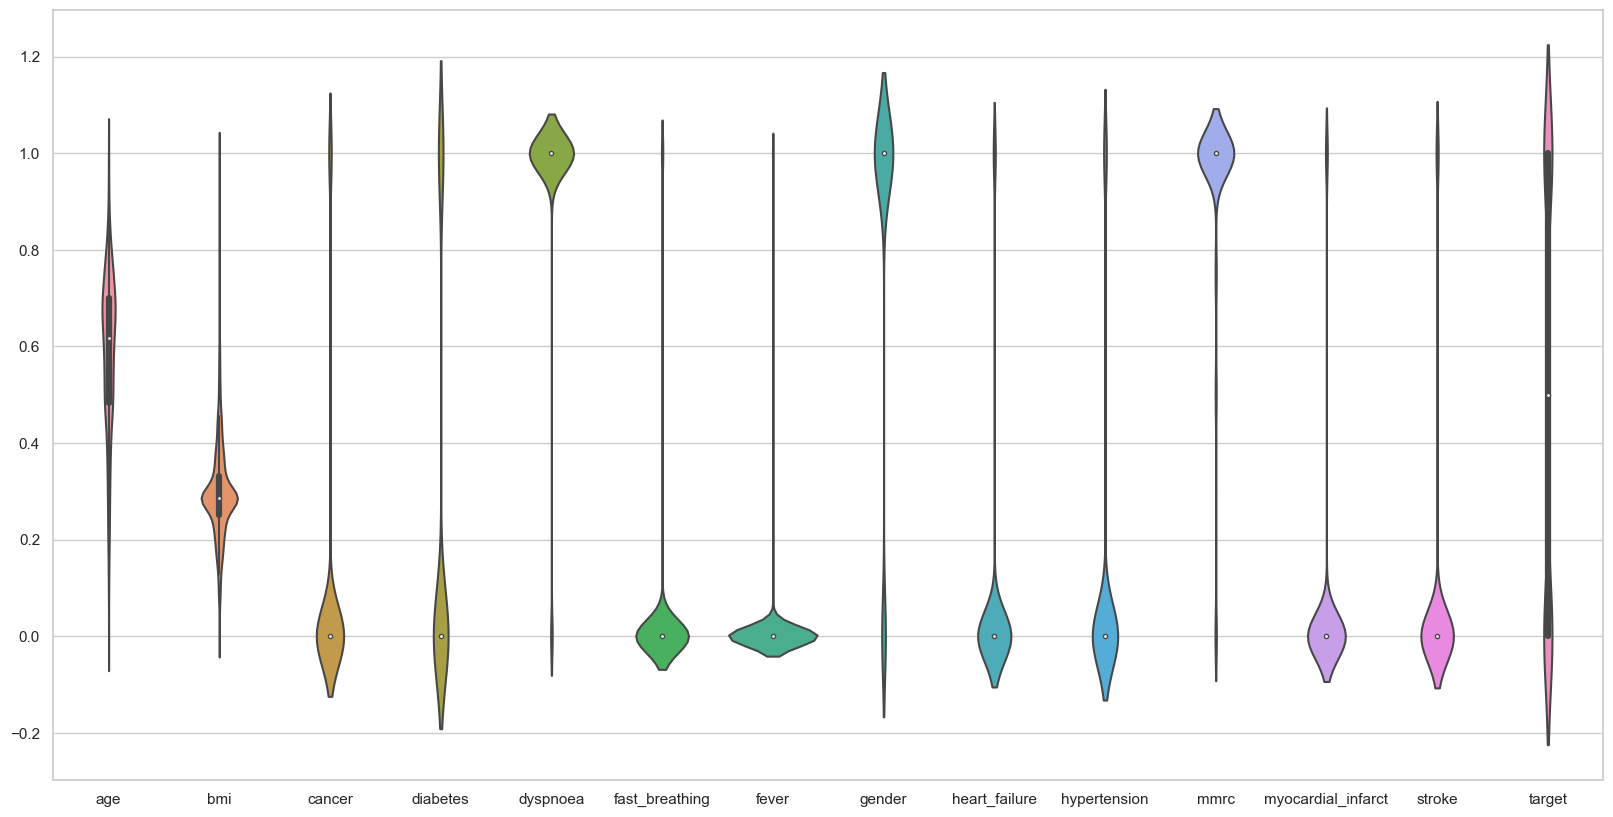

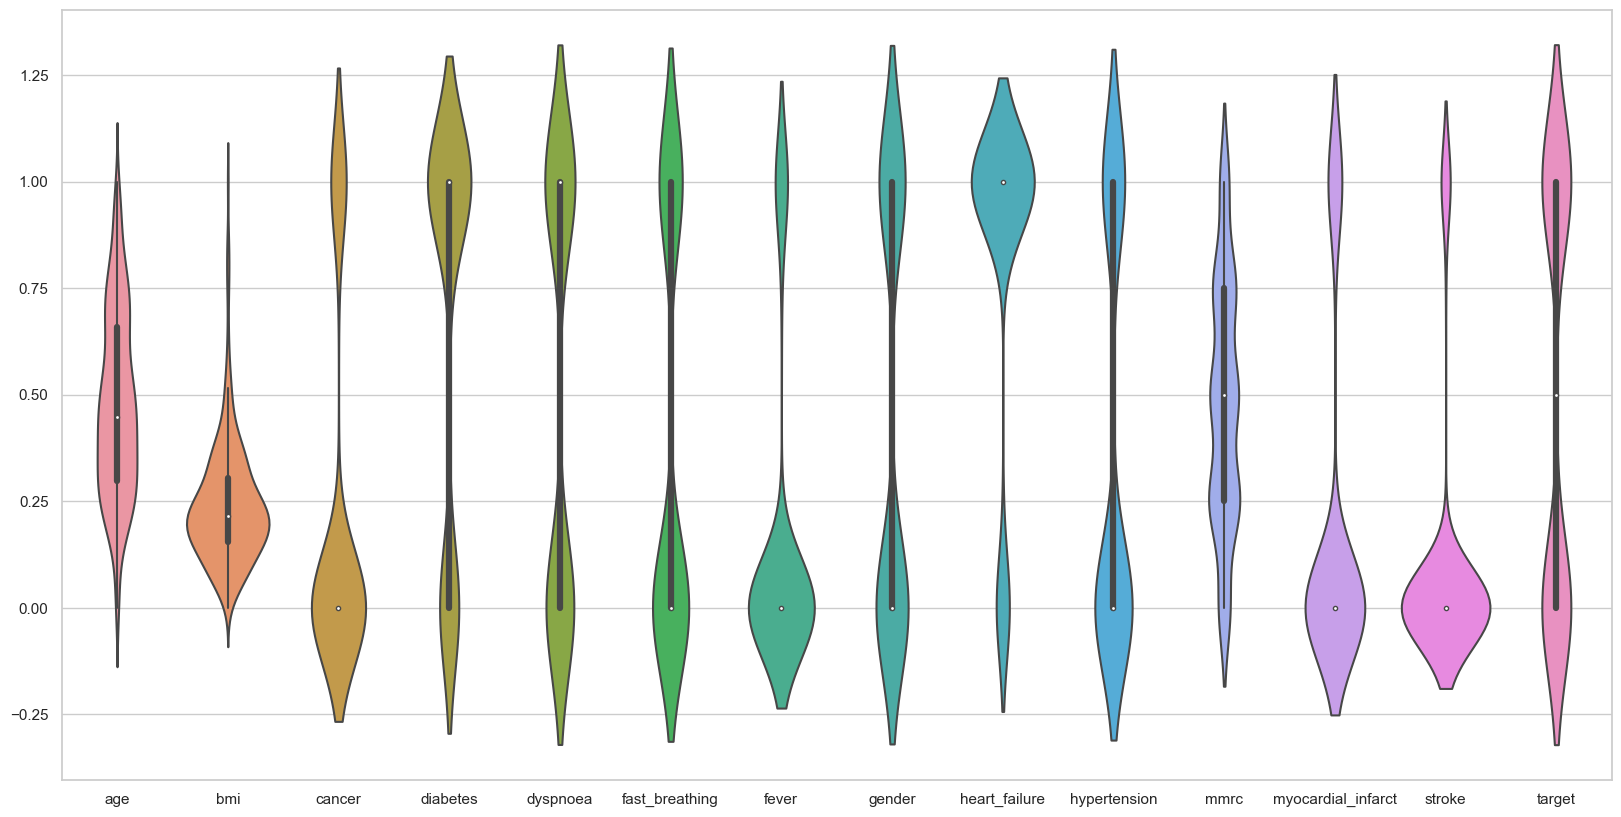

In [87]:
exaggerate = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=";")
harvard = pd.read_csv('harvard/data/exaggerate_cv.csv', sep=";")


# plot violin plot of all variables in exaggerate
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
ax = sns.violinplot(data=exaggerate)
plt.show()

# plot violin plot of all variables in harvard
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
ax = sns.violinplot(data=harvard)
plt.show()

### Radviz Plots

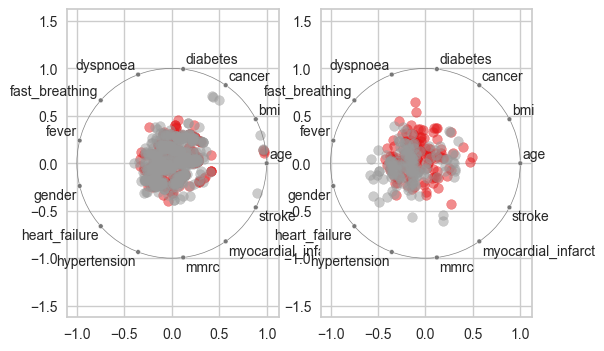

In [94]:
# create a yellowbricks radviz plot for each dataset in a 2x1 grid
from yellowbrick.features import RadViz

exaggerate = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=";")
harvard = pd.read_csv('harvard/data/exaggerate_cv.csv', sep=";")

# create the visualizer and draw the vectors
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
viz = RadViz(classes=[0, 1], features=exaggerate.drop(columns=["target"]).columns, size=(600, 400), alpha=0.5, colormap='Set1', ax=axs[0])
viz.fit(exaggerate.drop(columns=['target']), exaggerate['target'])
viz.transform(exaggerate.drop(columns=['target']))

viz = RadViz(classes=[0, 1], features=harvard.drop(columns=["target"]).columns, size=(600, 400), alpha=0.5, colormap='Set1', ax=axs[1])
viz.fit(harvard.drop(columns=['target']), harvard['target'])
viz.transform(harvard.drop(columns=['target']))

plt.show()


### PCA, Clustering and Manifold Learning

TypeError: Axes.scatter() got multiple values for argument 'ax'

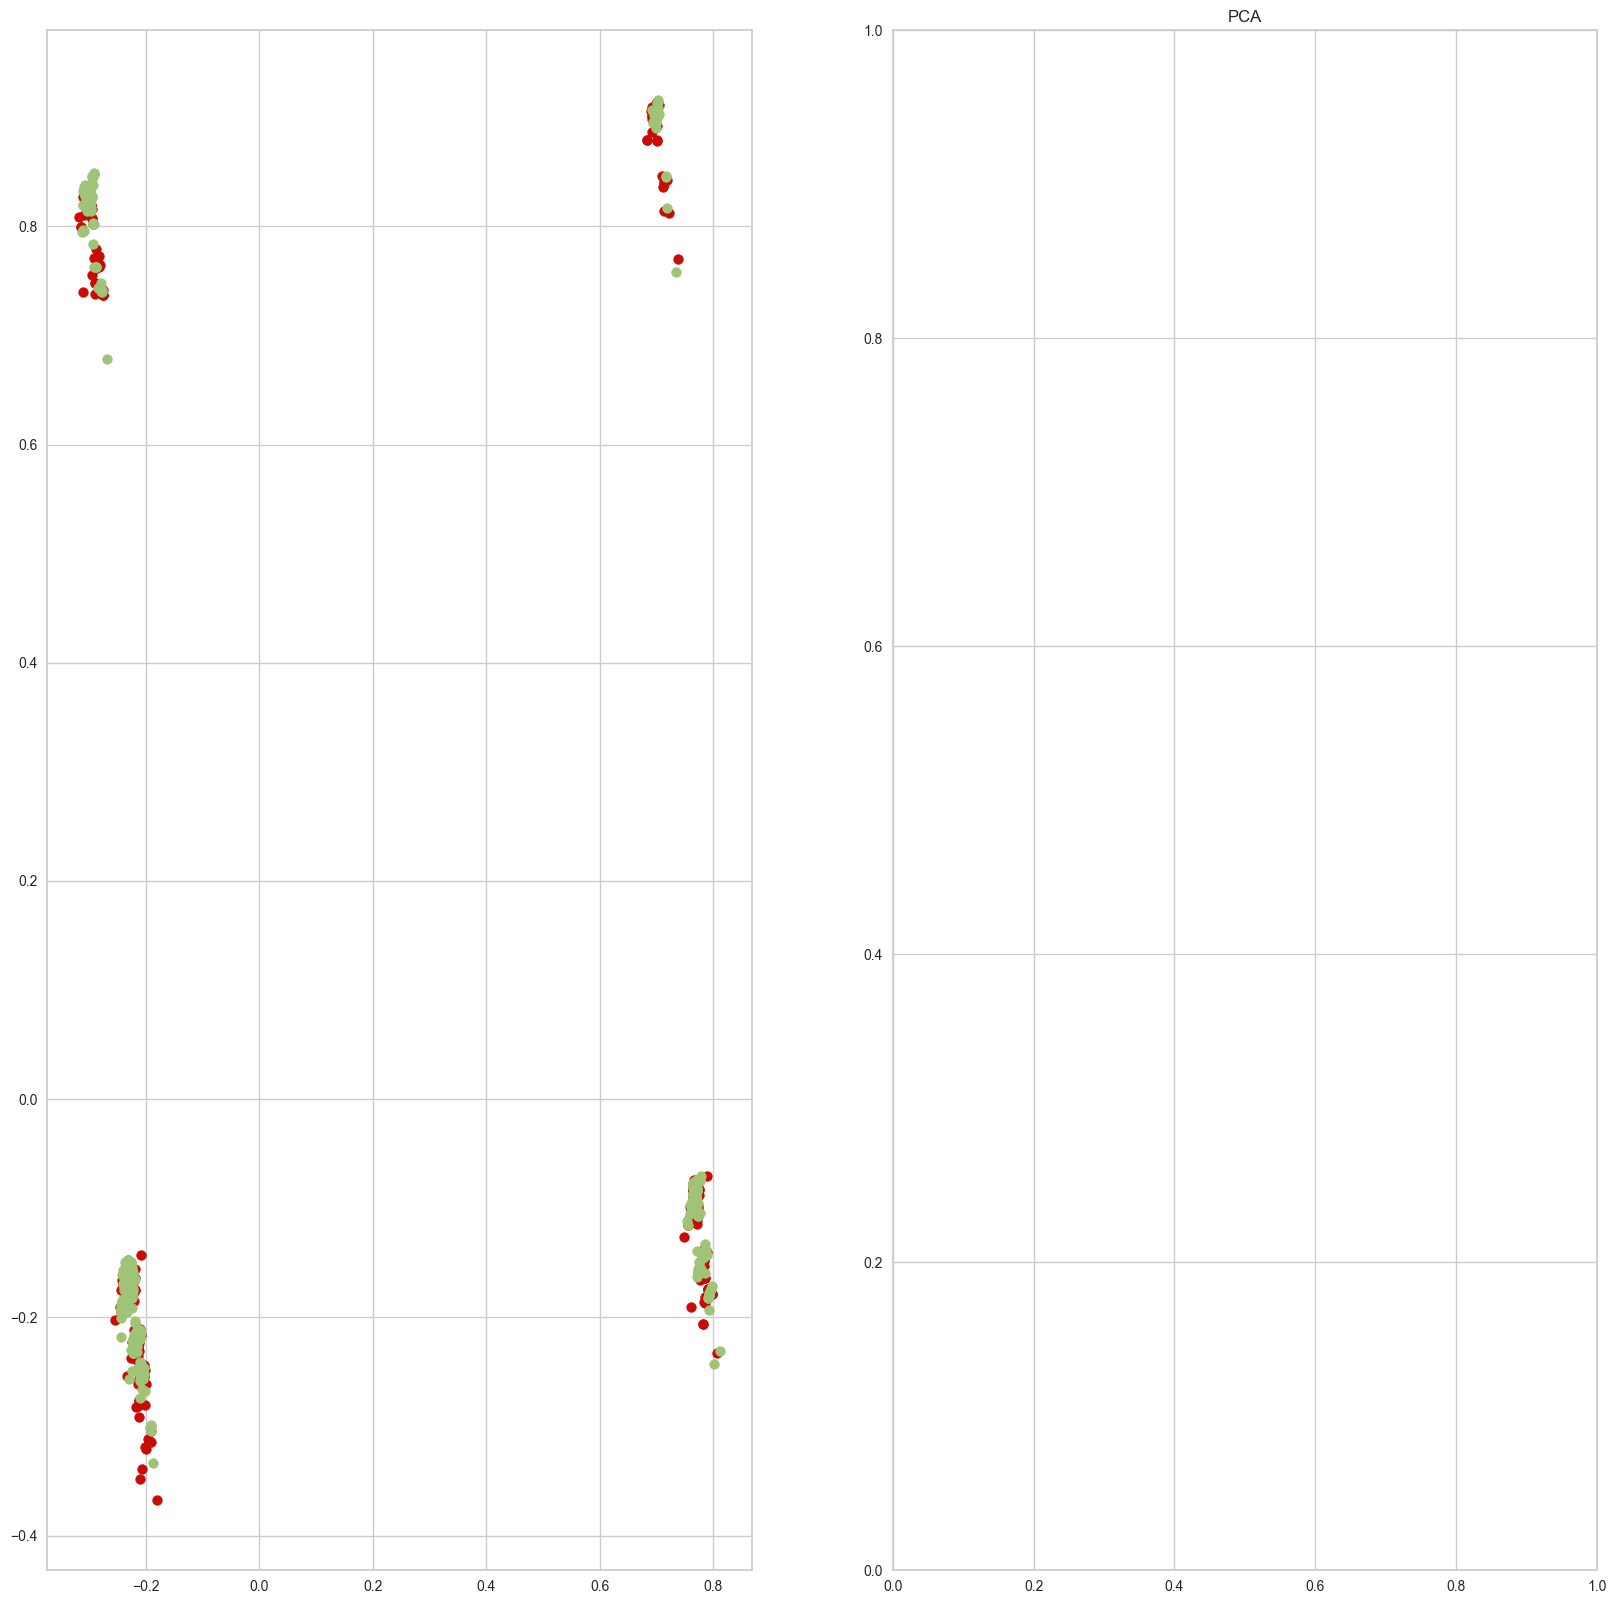

In [101]:
from sklearn.decomposition import PCA

# create two PCA scatterplots for each dataset in a 2x1 grid
fig, axs = plt.subplots(1, 2, figsize=(20, 20))

# PCA
pca = PCA(n_components=2)
features = pca.fit_transform(exaggerate.drop(columns=['target']))

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = exaggerate['target'] == target
    axs[0].scatter(features[indicesToKeep, 0], features[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('PCA')

pca = PCA(n_components=2)
features = pca.fit_transform(harvard.drop(columns=['target']))

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = harvard['target'] == target
    axs[1].scatter(features[indicesToKeep, 0], features[indicesToKeep, 1], c = color, s = 50, ax=axs[1])
plt.legend(targets)
plt.title('PCA')
plt.show()



# t-SNE
from sklearn.manifold import TSNE
from pandas import DataFrame, concat


X = np.asarray(features)
tsne = TSNE(n_components=2)
features_new = tsne.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = harvard['target'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('t-SNE')
plt.show()


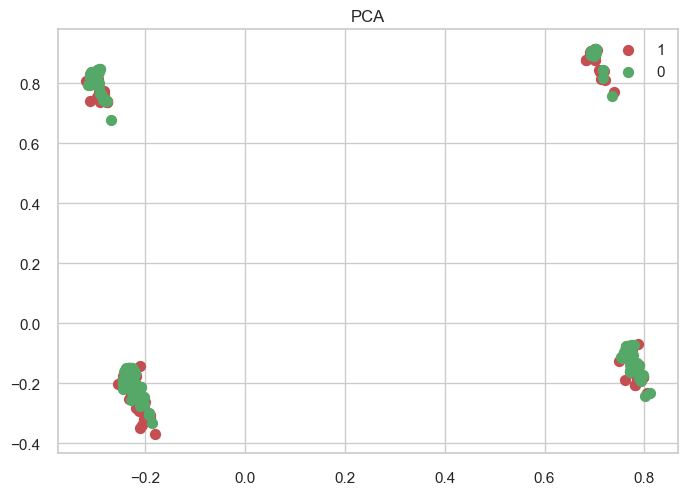

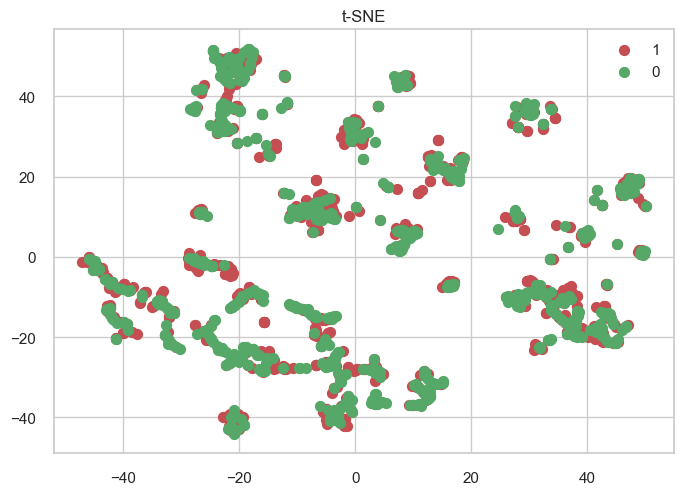

In [173]:
# PCA
from sklearn.decomposition import PCA
from pandas import DataFrame, concat
import numpy as np
import matplotlib.pyplot as plt

features = exaggerate.drop(columns=['target'])

X = np.asarray(features)
pca = PCA(n_components=2)
features_new = pca.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = exaggerate['target'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('PCA')
plt.show()

# t-SNE
from sklearn.manifold import TSNE
from pandas import DataFrame, concat


X = np.asarray(features)
tsne = TSNE(n_components=2)
features_new = tsne.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = exaggerate['target'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('t-SNE')
plt.show()

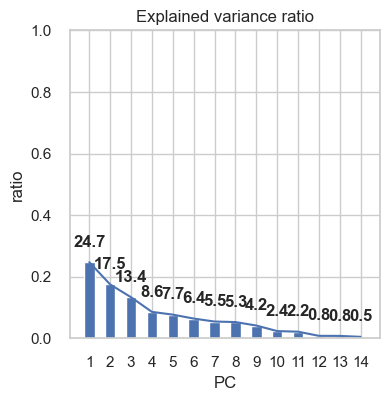

In [174]:
from matplotlib.pyplot import figure, xlabel, ylabel, scatter, show, subplots

from sklearn.decomposition import PCA
from numpy.linalg import eig
from matplotlib.pyplot import gca, title

mean = (exaggerate.mean(axis=0)).tolist()
centered_data = exaggerate - mean
cov_mtx = centered_data.cov()
eigvals, eigvecs = eig(cov_mtx)

pca = PCA()
pca.fit(centered_data)
PC = pca.components_
var = pca.explained_variance_

# PLOT EXPLAINED VARIANCE RATIO
fig = figure(figsize=(4, 4))
title('Explained variance ratio')
xlabel('PC')
ylabel('ratio')
x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
bwidth = 0.5
ax = gca()
ax.set_xticklabels(x_values)
ax.set_ylim(0.0, 1.0)
ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
ax.plot(pca.explained_variance_ratio_)
for i, v in enumerate(pca.explained_variance_ratio_):
    ax.text(i, v+0.05, f'{v*100:.1f}', ha='center', fontweight='bold')
show()



# Intra Dataset Training

In [85]:
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

exaggerate_data = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=';')
exaggerate_data = exaggerate_data[['fever', 'stroke', 'target']]

X = exaggerate_data.drop(columns=['target'])
y= exaggerate_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =123)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:00<00:00, 35.10it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.53,0.52,0.52,0.42,0.02
DummyClassifier,0.49,0.50,0.50,0.32,0.01
PassiveAggressiveClassifier,0.49,0.50,0.50,0.32,0.01
GaussianNB,0.51,0.50,0.50,0.35,0.01
QuadraticDiscriminantAnalysis,0.51,0.50,0.50,0.35,0.01
Perceptron,0.51,0.50,0.50,0.35,0.01
AdaBoostClassifier,0.47,0.48,0.48,0.33,0.07
LogisticRegression,0.47,0.48,0.48,0.33,0.01
XGBClassifier,0.47,0.48,0.48,0.33,0.04


In [86]:
# try out algorithms on harvard
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

harvard_data = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=';')
harvard_data = harvard_data[['fever', 'stroke', 'target']]

X = harvard.drop(columns=['target'])
y= harvard['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3,random_state =123)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:00<00:00, 53.06it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelSpreading,0.76,0.76,0.76,0.76,0.01
LabelPropagation,0.76,0.76,0.76,0.76,0.01
BaggingClassifier,0.75,0.76,0.76,0.75,0.02
ExtraTreesClassifier,0.74,0.74,0.74,0.74,0.08
DecisionTreeClassifier,0.73,0.73,0.73,0.73,0.01
LGBMClassifier,0.73,0.73,0.73,0.73,0.03
XGBClassifier,0.73,0.73,0.73,0.73,0.04
AdaBoostClassifier,0.72,0.72,0.72,0.72,0.06
RandomForestClassifier,0.71,0.71,0.71,0.71,0.10


# Inter Dataset training

In [77]:
import itertools
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from joblib import parallel_backend
# from lazypredict.Supervised import LazyClassifier

relevant_vars = ['gender', 'age', 'bmi', 'hypertension', 'cancer', 'diabetes', 'heart_failure', 'mmrc', 'fever', 'fast_breathing', 'myocardial_infarct', 'stroke', 'dyspnoea']
exaggerate_targets = ['death_aecopd', 'aecopd_12m']
harvard_targets = ['fclinra08', 'bclinra07', 'fclinra02', 'fclinicpt03', 'fclinpt04', 'fclinpt05', 'bclinpt24', 'bclinpt26', 'bclinpt22', 'bclinpt23', 'bclinra16']

exaggerate_data = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=';')
harvard_data = pd.read_csv('harvard/data/exaggerate_cv.csv', sep=';')

# get all possible sets of relevant variables
all_combinations = []
for i in range(1, len(relevant_vars)+1):
    combinations_object = itertools.combinations(relevant_vars, i)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list
    


classifiers = [GaussianNB(), XGBClassifier(), RandomForestClassifier(), LogisticRegression(), SVC(), KNeighborsClassifier()]

with parallel_backend('threading', n_jobs=-1):
    best_accuracy = 0
    best_model = None
    best_combination = None
    # go through all combinations and try out all algorithms
    for i, combination in enumerate(all_combinations):
        X_train = exaggerate_data[list(combination)]
        y_train = exaggerate_data['target']

        X_test = harvard_data[list(combination)]
        y_test = harvard_data['target']
        for clf in classifiers:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = clf
                best_combination = combination
                # write combination, accuracy and model to csv
                with open('results.csv', 'a') as f:
                    f.write(f'{combination};{accuracy};{clf}\n')
        # print something if multiples of 5% are done
        if i % (len(all_combinations) / 20) == 0:
            print(f'{i / len(all_combinations) * 100:.1f}%')

print(best_combination)
print(best_model)
print(best_accuracy)
    
    

















0.0%
('stroke', 'dyspnoea')
KNeighborsClassifier()
0.7585034013605442


In [76]:
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier

exaggerate = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=';')
harvard = pd.read_csv('harvard/exaggerate_cv.csv', sep=';')

# take a subset from both datasets including these variables
subset = ['fever', 'stroke', 'dyspnoea', 'target']
exaggerate = exaggerate[subset]
harvard = harvard[subset]

# create trainset from exaggerate
X_train = exaggerate.drop(columns=['target'])
y_train = exaggerate['target']

# create testset from harvard
X_test = harvard.drop(columns=['target'])
y_test = harvard['target']

# train on exaggerate and test on harvard
# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, random_state=42, predictions=True)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

# perform hyperparameter optimization for knn
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = RandomForestClassifier()
# parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'p': [1, 2]}
# clf = GridSearchCV(knn, parameters, cv=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))
# print(clf.best_params_)
# print(clf.best_score_)
# print(clf.best_estimator_)

0.6530612244897959


In [119]:
# perform hyperparameter tuning for passive aggressive classifier, xgboost, decision tree and random forest
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# split exaggerate into train and validation set

from sklearn.model_selection import train_test_split

# training set is the entire exaggerate dataset
X_train = exaggerate.drop(columns=['target'])
y_train = exaggerate['target']

# validation set is 30% of the harvard dataset
X_val, X_test, y_val, y_test = train_test_split(harvard.drop(columns=['target']), harvard['target'], test_size=0.3, random_state=42)

# train on trainset and validate on validation set
# passive aggressive classifier
# param_grid = {'C': [0.1, 1, 10, 100, 1000], 'fit_intercept': [True, False], 'max_iter': [100, 1000, 2500, 5000, 10000, 25000, 50000], 'tol': [1e-3, 1e-4, 1e-5]}
# grid = GridSearchCV(PassiveAggressiveClassifier(), param_grid, refit = True, n_jobs=-1)
# print("PassiveAggressiveClassifier")
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# print(grid.best_estimator_)
# print(grid.best_score_)
# print(grid.score(X_val, y_val))

# random forest
# param_grid = {'n_estimators': [100, 200, 500, 1000], 'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
# print("RandomForestClassifier")
# grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, n_jobs=-1)
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# print(grid.best_estimator_)
# print(grid.best_score_)
# print(grid.score(X_val, y_val))

# decision tree
# param_grid = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
# print("DecisionTreeClassifier")
# grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit = True, n_jobs=-1)
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# print(grid.best_estimator_)
# print(grid.best_score_)
# print(grid.score(X_val, y_val))

# xgboost
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'n_estimators': [100, 200, 500, 1000], 'min_child_weight': [1, 3, 5, 7], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'colsample_bytree': [0.3, 0.4, 0.5, 0.7]}
print("XGBClassifier")
grid = GridSearchCV(XGBClassifier(), param_grid, refit = True, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)
print(grid.score(X_val, y_val))

# test the best XGBclassifier on the entire harvard dataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_test = harvard.drop(columns=['target'])
y_test = harvard['target']
# predict using best classifier
y_pred = grid.predict(X_test)
# print accuracy score
print("Accuracy:",accuracy_score(y_test, y_pred))
# print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
# print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))



# use the best classifer 

XGBClassifier
{'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
0.6918918918918918
0.5330508474576271
Accuracy: 0.5260972716488731
Confusion Matrix:
[[ 453 1233]
 [ 365 1321]]
Classific

In [155]:
# test best model on havard
# use xgboost with {'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 500}
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

X_train = exaggerate.drop(columns=['target'])
y_train = exaggerate['target']

X_test = harvard.drop(columns=['target'])
y_test = harvard['target']

model = XGBClassifier(colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.47959183673469385


In [168]:
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier


# create trainset from exaggerate
X_train = harvard.drop(columns=['target'])
y_train = harvard['target']

# create testset from harvard
X_test = exaggerate.drop(columns=['target'])
y_test = exaggerate['target']

# train on exaggerate and test on harvard
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, random_state=42, predictions=True)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:00<00:00, 37.49it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreeClassifier,0.52,0.52,0.52,0.40,0.01
BernoulliNB,0.50,0.50,0.50,0.37,0.01
BaggingClassifier,0.50,0.50,0.50,0.46,0.03
ExtraTreesClassifier,0.50,0.50,0.50,0.50,0.10
DecisionTreeClassifier,0.50,0.50,0.50,0.40,0.01
DummyClassifier,0.50,0.50,0.50,0.33,0.01
LGBMClassifier,0.50,0.50,0.50,0.48,0.04
XGBClassifier,0.50,0.50,0.50,0.49,0.04
Perceptron,0.50,0.50,0.50,0.40,0.01


In [ ]:
from sklearn.linear_model import Perceptron

# try training on harvard and testing on exaggerate

# train on PCA transformed harvard dataset
from sklearn.decomposition import PCA
X = harvard.drop(columns=['target'])
pca = PCA(n_components=5)
X_train = pca.fit_transform(X)


# X_train = harvard_data.drop(columns=['target'])
y_train = harvard['target']

# test on PCA transformed exaggerate dataset
from sklearn.decomposition import PCA
X = exaggerate.drop(columns=['target'])
pca = PCA(n_components=5)
X_test = pca.fit_transform(X)

# X_test = exaggerate_data.drop(columns=['target'])
y_test = exaggerate['target']

LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

# clf = Perceptron(tol=1e-3, random_state=0)
# clf.fit(X_train, y_train)
# print(clf.score(X_test, y_test))